In [1]:
import time
import matplotlib as plt
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        ptbins = np.array([200,250,300,350,400,450,500,
                            600,700,800,900,1000,
                            1500,2000,3000,4000,5000])
        mbins = np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,120,140,160,180,200,250,300,350,400,])
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_reco_axis = hist.Bin("pt_reco_axis", r"$Reco p_{T}$ [GeV]", ptbins)
        pt_gen_axis = hist.Bin("pt_gen_axis", r"$Gen p_{T}$ [GeV]", ptbins)
        m_reco_axis = hist.Bin("m_reco_axis", r" Reco $m$ [GeV]", mbins)
        m_gen_axis = hist.Bin("m_gen_axis", r"Gen $m$ [GeV]", mbins)
        dr_axis = hist.Bin("dr", r"$\Delta R$", np.linspace(0, 8, 100) )
        #gen_axis = hist.Bin("gen_axis", r"Gen?", 0,100, 20)
        #reco_axis = hist.Bin("reco_axis", r"Reco?", 0,100, 20)

        
        self._accumulator = processor.dict_accumulator({
            'h_dr_all':hist.Hist("Counts", dataset_axis, dr_axis ),
            'h_dr_reco':hist.Hist("Counts", dataset_axis, dr_axis ),
            'h_pt_m_reco_pre':hist.Hist("Counts", dataset_axis, pt_reco_axis, m_reco_axis),
            'h_pt_m_gen_pre':hist.Hist("Counts", dataset_axis, pt_gen_axis, m_gen_axis),
            'h_pt_m_reco':hist.Hist("Counts", dataset_axis, pt_reco_axis, m_reco_axis),
            'h_pt_m_gen':hist.Hist("Counts", dataset_axis, pt_gen_axis, m_gen_axis),
            'h_response':hist.Hist("Counts", dataset_axis, pt_gen_axis, m_gen_axis, pt_reco_axis, m_reco_axis),
            #'h_2dresponse':hist.Hist("Counts", dataset_axis, gen_axis, reco_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

#         print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            jetId=df['FatJet_jetId']
            )        
        
        GenJets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJetAK8'],
            pt=df['GenJetAK8_pt'],
            eta=df['GenJetAK8_eta'],
            phi=df['GenJetAK8_phi'],
            mass=df['GenJetAK8_mass']
            )
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += Jets.size

        jetId_cut = (Jets.jetId > 0)        
        Jets = Jets[jetId_cut]
        output['cutflow']['>=1 with loose id'] += jetId_cut.any().sum()
        twoJets_cut = (Jets.counts >= 2)        
        output['cutflow']['>=2 reco jets'] += twoJets_cut.sum()
        twoGens_cut = (GenJets.counts >= 2)
        output['cutflow']['>=2 gen jets'] += twoGens_cut.sum()
        

        twoJets = Jets[twoJets_cut]
        twoGenJets = GenJets[twoGens_cut]
        dphireco = twoJets.p4[:,0].delta_phi( twoJets.p4[:,1] )
        dphigen = twoGenJets.p4[:,0].delta_phi( twoGenJets.p4[:,1] )
        dphi_index_reco =  (dphireco > 0.5*np.pi) & (dphireco < 1.5*np.pi)
        dphi_index_gen =  (dphigen > 0.5*np.pi) & (dphigen < 1.5*np.pi)
        #print('dphi_index shape', dphi_index.shape)
        #print('Jets shape', Jets.shape)
        #print('Gens shape', GenJets.shape)
        output['cutflow']['dPhi > Pi/2'] += dphi_index_reco.sum()
        output['cutflow']['dPhi Gen > Pi/2'] += dphi_index_gen.sum()
        
        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
#         print("pairing shape:", pairing.shape)
        output['h_dr_all'].fill(dataset=dataset, dr = metric.flatten().flatten() )        
        
        #print('pt asymm')
        pt_asymm_index_reco = (twoJets.p4[:,0].pt -  twoJets.p4[:,1].pt )/(twoJets.p4[:,0].pt +  twoJets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (twoGenJets.p4[:,0].pt -  twoGenJets.p4[:,1].pt )/(twoGenJets.p4[:,0].pt +  
                                                                                twoGenJets.p4[:,1].pt ) < 0.3
        output['cutflow']['pt asymmetry < 0.3'] += pt_asymm_index_reco.sum()
        output['cutflow']['pt Asymmetry Gen < 0.3'] += pt_asymm_index_gen.sum()

        twoJets = twoJets[pt_asymm_index_reco & dphi_index_reco]
        twoGenJets = twoGenJets[pt_asymm_index_gen & dphi_index_gen]
        
#         print("Jets shape ", Jets.shape)
#         print("GenJets shape ", GenJets.shape)
        
        output['h_pt_m_reco_pre'].fill(dataset = dataset, pt_reco_axis = twoJets.pt.flatten(),
                                   m_reco_axis = twoJets.mass.flatten().flatten())
        output['h_pt_m_gen_pre'].fill(dataset = dataset, pt_gen_axis = twoGenJets.pt.flatten(), 
                                  m_gen_axis = twoGenJets.mass.flatten())
        
        Jets = Jets[twoJets_cut & twoGens_cut]
        GenJets = GenJets[twoJets_cut & twoGens_cut]
        
        dphireco = Jets.p4[:,0].delta_phi( Jets.p4[:,1] )
        dphigen = GenJets.p4[:,0].delta_phi( GenJets.p4[:,1] )
        dphi_index_reco = (dphireco > 0.5*np.pi) & (dphireco < 1.5*np.pi)
        dphi_index_gen =  (dphigen > 0.5*np.pi) & (dphigen < 1.5*np.pi)
        pt_asymm_index_reco = (Jets.p4[:,0].pt -  Jets.p4[:,1].pt )/(Jets.p4[:,0].pt +  Jets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (GenJets.p4[:,0].pt -  GenJets.p4[:,1].pt )/(GenJets.p4[:,0].pt + GenJets.p4[:,1].pt ) < 0.3
        
        
        Jets = Jets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        GenJets = GenJets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        
        
        #print(GenJets.shape, dphi_index_gen.shape, pt_asymm_index_gen.shape, Jets.shape)
#         Jets = Jets[dphi_index_gen & pt_asymm_index_gen]
    
#         GenJets = GenJets[dphi_index_reco & pt_asymm_index_reco]

        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
#         print("pairing shape:", pairing.shape)
        output['h_dr_reco'].fill(dataset=dataset, dr = metric.flatten().flatten() )
        index_of_minimized = metric.argmin()
        dr_cut = (metric[index_of_minimized] < 0.4)
        best_pairings_that_pass_dr_cut = pairing[index_of_minimized][dr_cut]
        genrecos = best_pairings_that_pass_dr_cut.flatten(axis=1)
        #print("genrecos shape:", genrecos.shape)
        #ptresponse = genrecos.i0.pt / genrecos.i1.pt
        
        output['h_pt_m_reco'].fill(dataset = dataset, pt_reco_axis = genrecos.i0.pt.flatten(),
                                   m_reco_axis = genrecos.i0.mass.flatten()
                                  )
        output['h_pt_m_gen'].fill(dataset = dataset, pt_gen_axis = genrecos.i1.pt.flatten(),
                                   m_gen_axis = genrecos.i1.mass.flatten()
                                  )
        output['h_response'].fill(dataset = dataset, 
                                  pt_gen_axis = genrecos.i1.pt.flatten(), 
                                  pt_reco_axis = genrecos.i0.pt.flatten(),
                                  m_gen_axis = genrecos.i1.mass.flatten(), 
                                  m_reco_axis = genrecos.i0.mass.flatten() )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
   

# Get the sample metadata
samples = json.load( open('samples_qcdflat.json') )

prefix = '/mnt/data/cms/store/mc/RunIIFall17NanoAODv5/'
fileset = {}
for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    fileset[name] = glob.glob(prefix + name + '/*/*/*/*.root')
    
    
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyJECL2L3Processor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=500000,
                                 )


elapsed = time.time() - tstart
print(output)


{'h_dr_all': <Hist (dataset,dr) instance at 0x7f5d0fc6ee10>, 'h_dr_reco': <Hist (dataset,dr) instance at 0x7f5d0fc6ec50>, 'h_pt_m_reco_pre': <Hist (dataset,pt_reco_axis,m_reco_axis) instance at 0x7f5d0fd08fd0>, 'h_pt_m_gen_pre': <Hist (dataset,pt_gen_axis,m_gen_axis) instance at 0x7f5d0fd08d68>, 'h_pt_m_reco': <Hist (dataset,pt_reco_axis,m_reco_axis) instance at 0x7f5d0fc26630>, 'h_pt_m_gen': <Hist (dataset,pt_gen_axis,m_gen_axis) instance at 0x7f5d0fc26668>, 'h_response': <Hist (dataset,pt_gen_axis,m_gen_axis,pt_reco_axis,m_reco_axis) instance at 0x7f5d0fc265c0>, 'cutflow': defaultdict(<class 'int'>, {'all events': 18455107, '>=1 with loose id': 10092589, '>=2 reco jets': 8547127, '>=2 gen jets': 12036489, 'dPhi > Pi/2': 4264880, 'dPhi Gen > Pi/2': 6008833, 'pt asymmetry < 0.3': 8374722, 'pt Asymmetry Gen < 0.3': 11819408})}


In [4]:
print('Processed %d events in %6.2f s = %6.2f Hz' % (output['cutflow']['all events'], elapsed, output['cutflow']['all events']/elapsed))

Processed 18455107 events in  75.30 s = 245074.18 Hz


In [5]:
output['cutflow']

defaultdict_accumulator(int,
                        {'all events': 18455107,
                         '>=1 with loose id': 10092589,
                         '>=2 reco jets': 8547127,
                         '>=2 gen jets': 12036489,
                         'dPhi > Pi/2': 4264880,
                         'dPhi Gen > Pi/2': 6008833,
                         'pt asymmetry < 0.3': 8374722,
                         'pt Asymmetry Gen < 0.3': 11819408})

In [6]:
import matplotlib.pyplot as plt

### $m_u$ plot

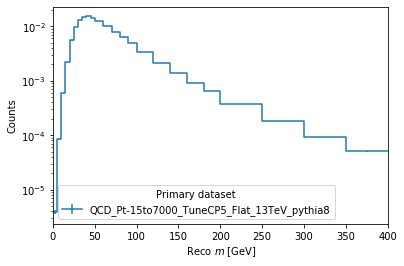

In [7]:
fig, ax = hist.plotgrid(output['h_pt_m_reco_pre'].sum("pt_reco_axis"), overlay="dataset", stack=False, density=True
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

### $p_T$ plot

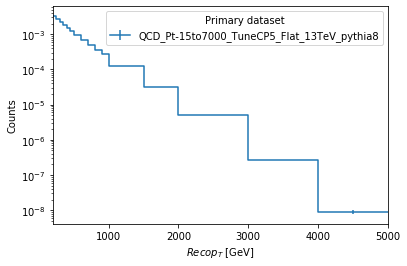

In [8]:
fig, ax = hist.plotgrid(output['h_pt_m_reco_pre'].sum("m_reco_axis"), overlay="dataset", stack=False, density=True
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

### $\Delta R$ between reco and closest gen jet

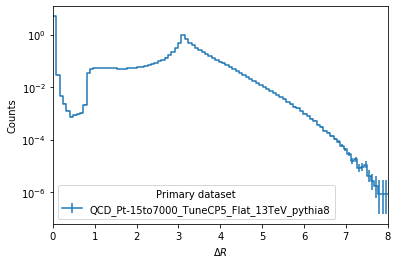

In [9]:
fig, ax = hist.plotgrid(output['h_dr_reco'], overlay="dataset", stack=False, density=True
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

### Observed $p_T$ versus $m_u$

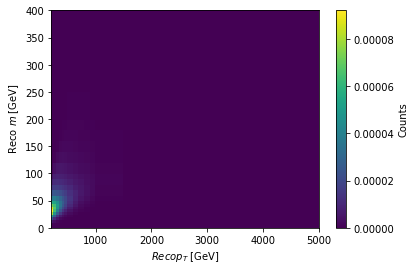

In [10]:
fig, ax, _ = hist.plot2d(output['h_pt_m_reco_pre'].sum("dataset"), xaxis="pt_reco_axis", density=True)


### Get the histograms, divide by bin width

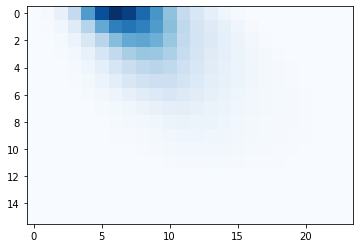

In [11]:
h_pt_m_reco_pre_vals = output['h_pt_m_reco_pre'].sum("dataset").values()[()]
pt_edges = output['h_pt_m_reco_pre'].sum("dataset").axis("pt_reco_axis").edges()
m_edges = output['h_pt_m_reco_pre'].sum("dataset").axis("m_reco_axis").edges()
h_pt_m_reco_pre_norm = h_pt_m_reco_pre_vals / np.diff(m_edges)/ np.diff(pt_edges)[:, np.newaxis] 
plt.imshow(h_pt_m_reco_pre_norm, cmap="Blues")


### Plot the raw numbers with normalization for $m_u$

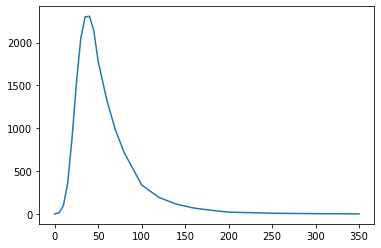

In [12]:
plt.plot( m_edges[:-1], np.sum(h_pt_m_reco_pre_norm, axis=0) )

### Plot the raw numbers with normalization for $p_T$

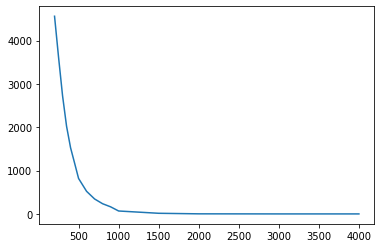

In [13]:
plt.plot( pt_edges[:-1], np.sum(h_pt_m_reco_pre_norm, axis=1) )

### Get response matrix, divide by bin widths

In [14]:
h = output['h_response'].values()[('QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8',)]

In [15]:
pt_reco_edges = output['h_response'].axis("pt_reco_axis").edges()
m_reco_edges = output['h_response'].axis("m_reco_axis").edges()
pt_gen_edges = output['h_response'].axis("pt_gen_axis").edges()
m_gen_edges = output['h_response'].axis("m_gen_axis").edges()

h = h / np.diff( pt_reco_edges )[:, np.newaxis]
h = h / np.diff( m_reco_edges )[:, np.newaxis, np.newaxis]
h = h / np.diff( pt_gen_edges )[:, np.newaxis]
h = h / np.diff( m_gen_edges )[:, np.newaxis, np.newaxis]

### Plot 2d projection of 4d response matrix

In [16]:
h2 = h.reshape(  16*24, 16*24 )

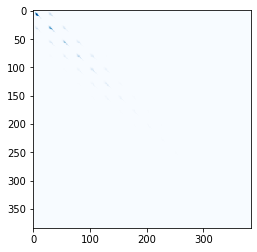

In [17]:
plt.imshow(h2, cmap="Blues")

### Plot all reco distributions, unrolled. 

<BarContainer object of 384 artists>

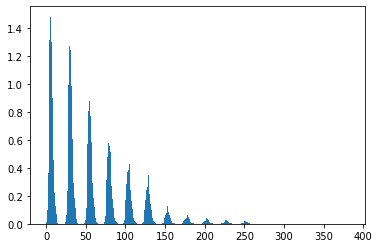

In [18]:
plt.bar( np.arange(0,h2.shape[0]), np.sum(h2, axis=0), width=-1, align='edge')

### Plot all gen distributions, unrolled. 

<BarContainer object of 384 artists>

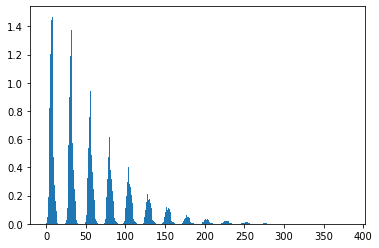

In [19]:
plt.bar( np.arange(0,h2.shape[1]),  np.sum(h2, axis=1), width=-1, align='edge' )
#plt.xlim(8*24,9*24)
#plt.ylim(0,0.25)

### Plot response matrix normalized per column

In [20]:
colnorm = np.sum(h2, axis=0)
hnorm = h2 / np.where( colnorm > 0, colnorm, 1.0 )

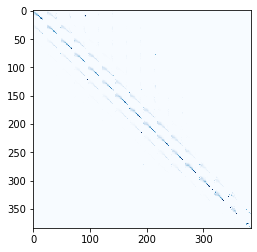

In [21]:
plt.imshow(hnorm, cmap="Blues", vmax=0.5)